# Patch Inference

Seed set to 0


weights


C:\Documents\RoofSense\venv\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Documents\RoofSense\training\dataset.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(


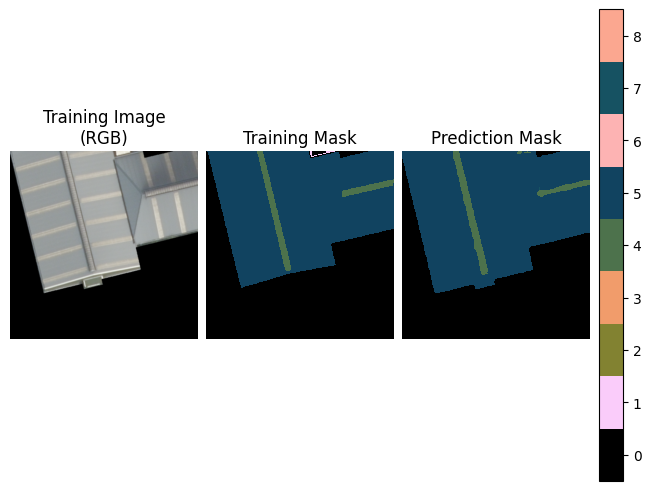

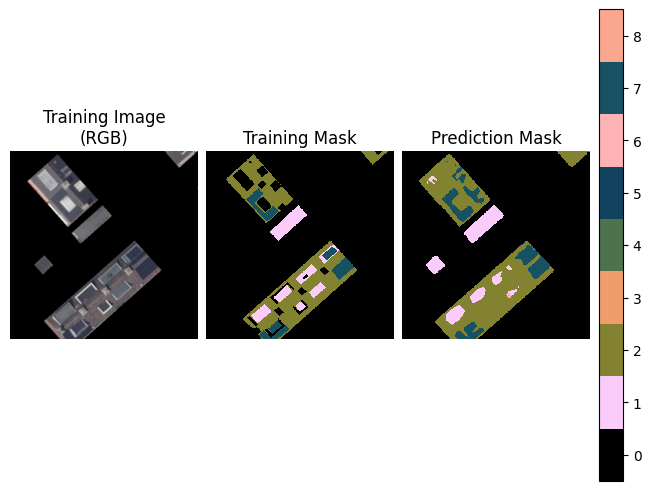

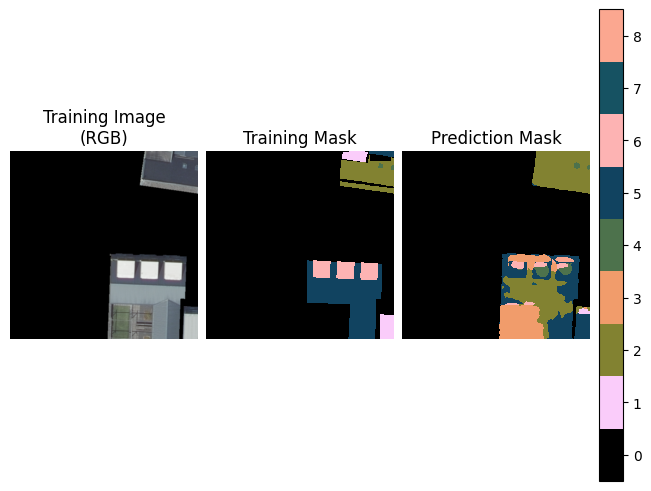

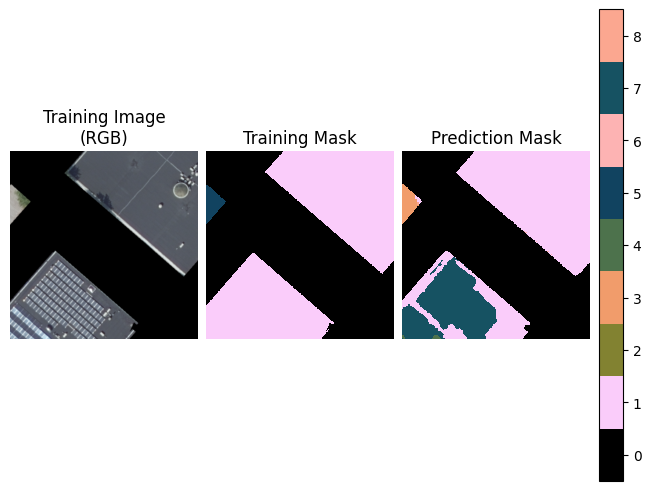

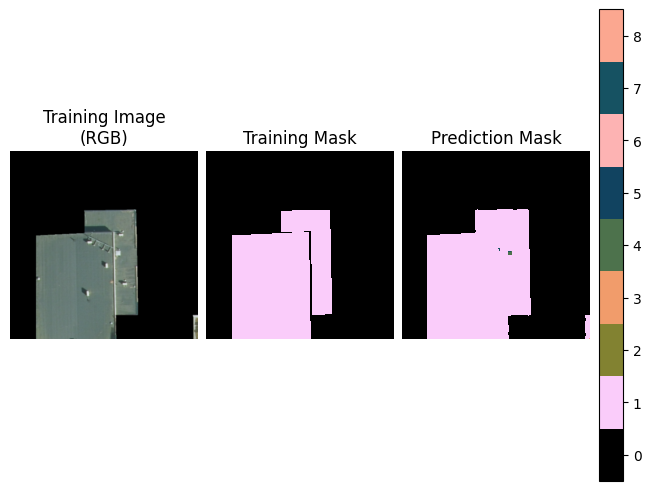

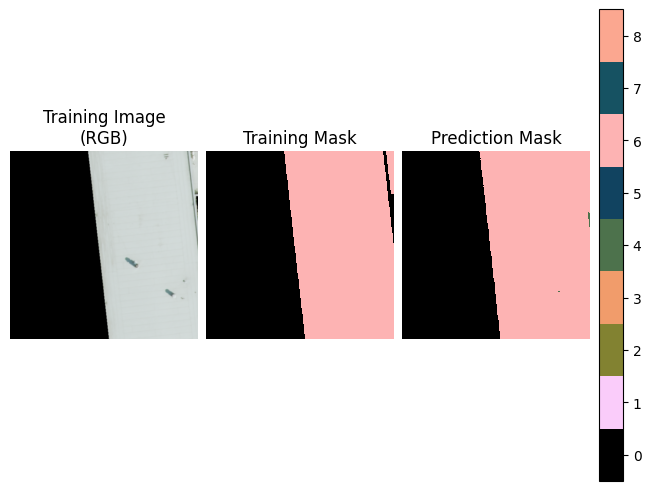

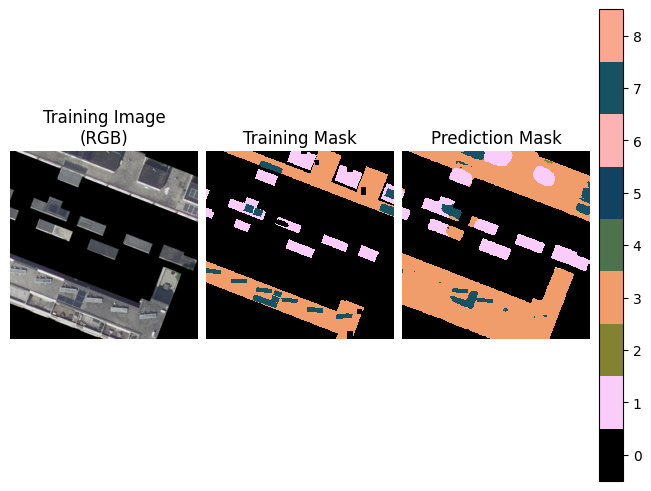

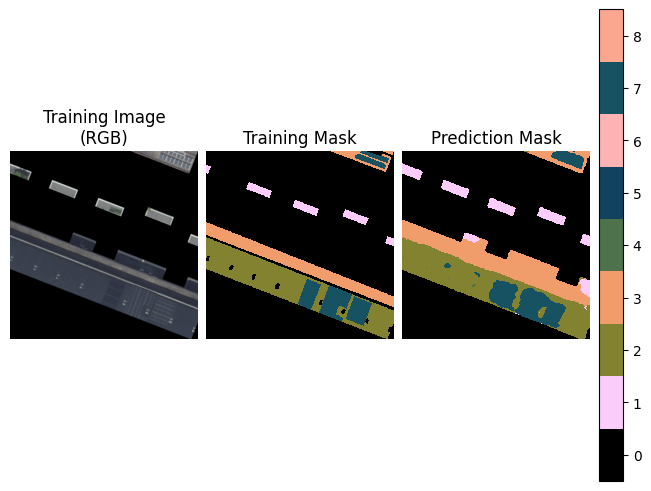

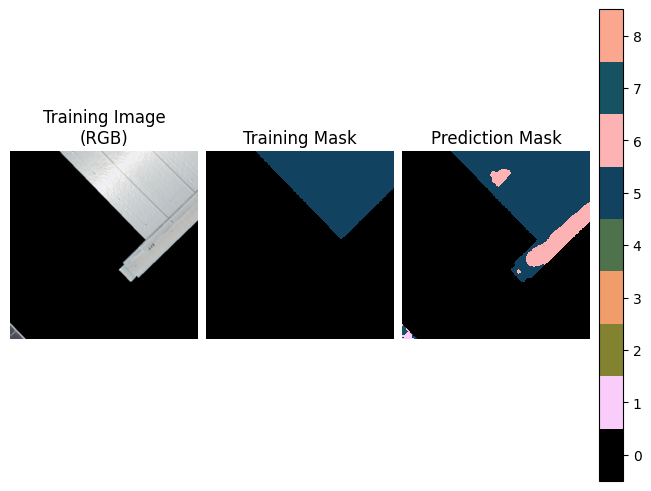

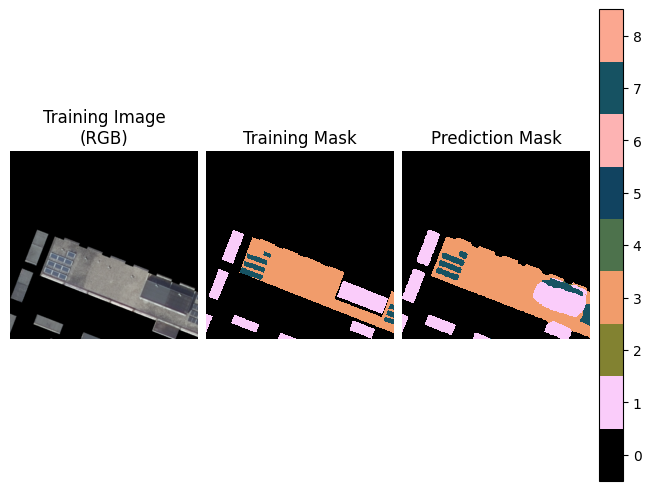

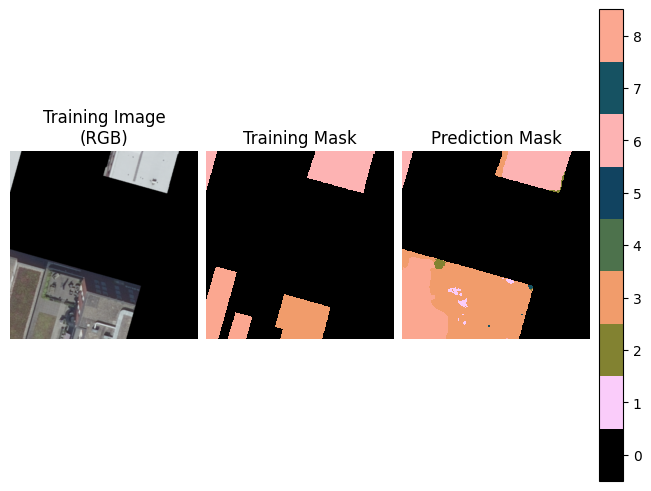

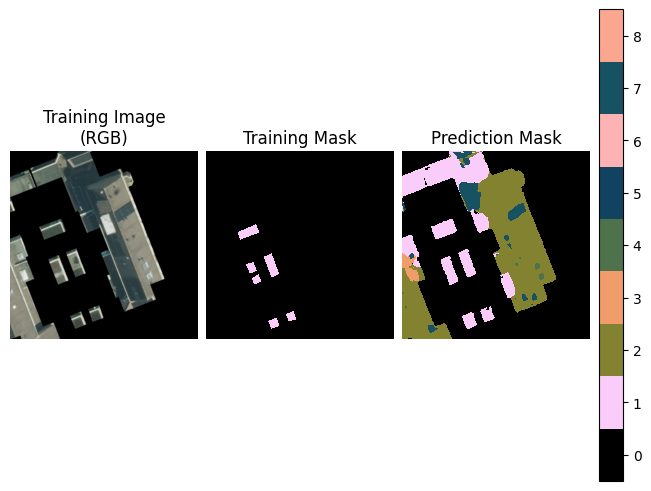

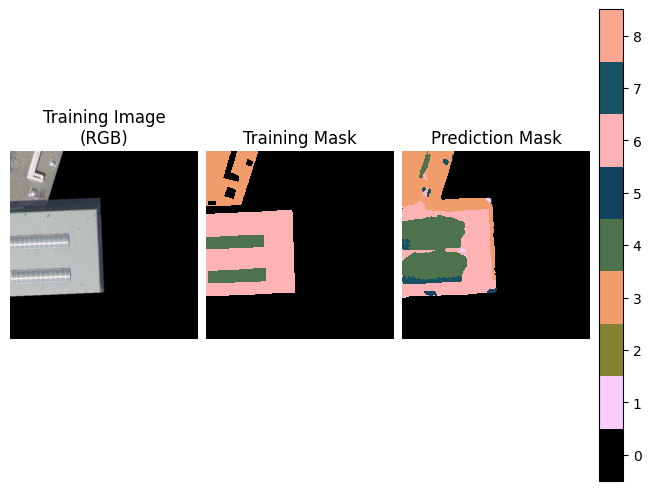

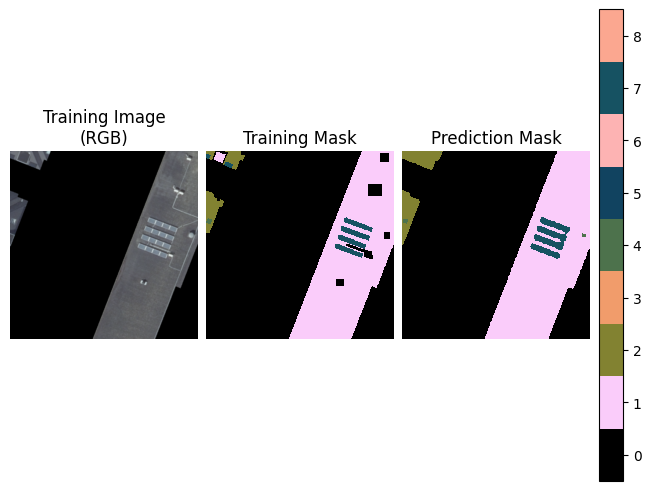

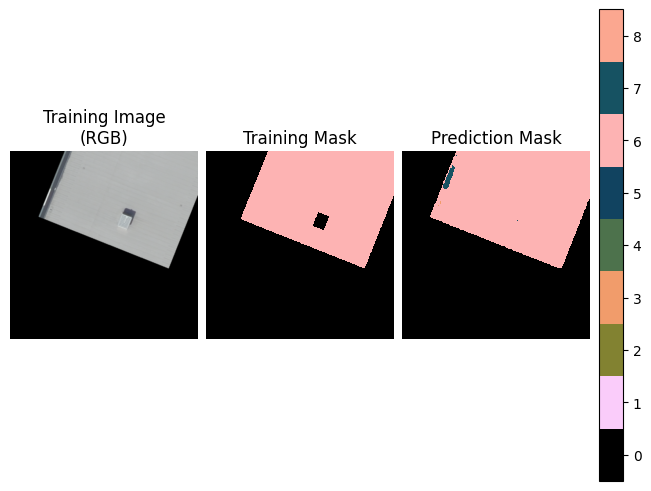

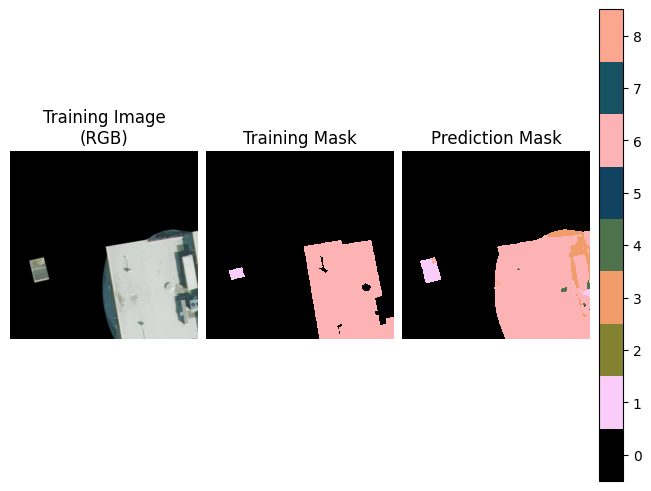

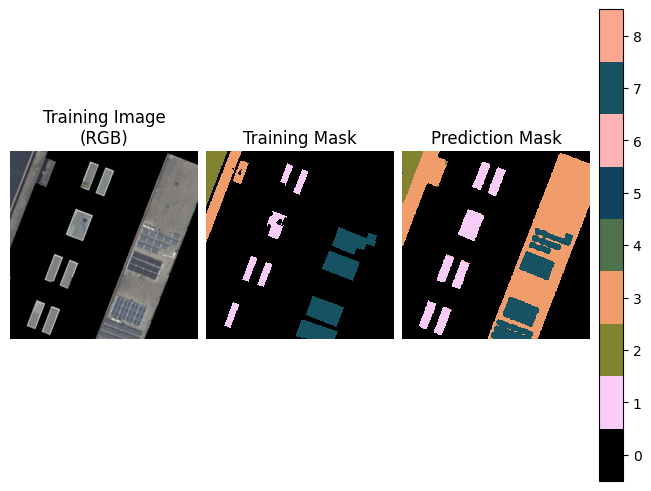

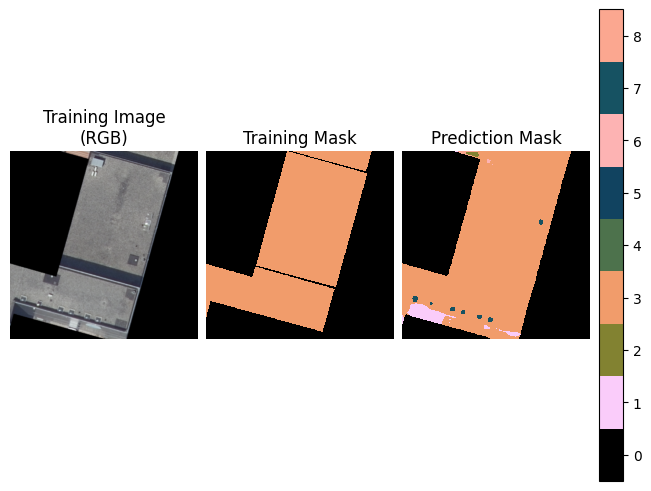

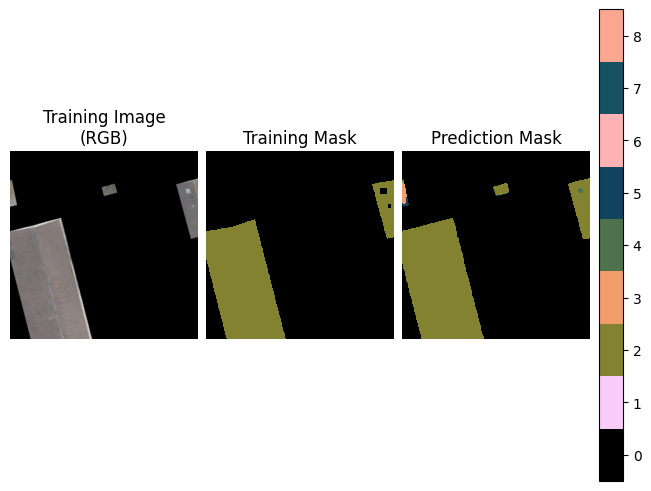

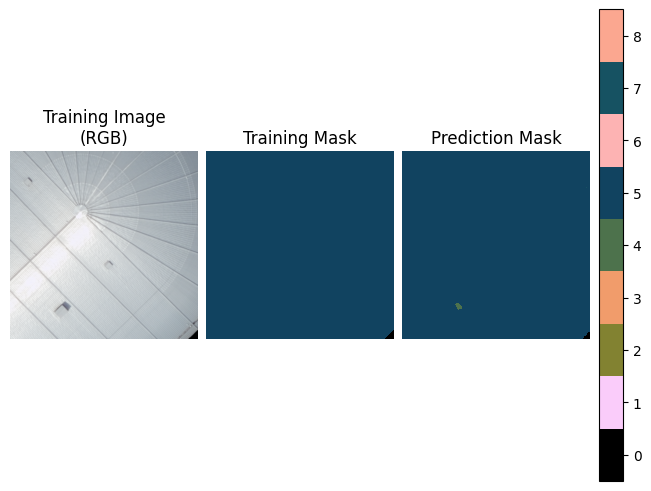

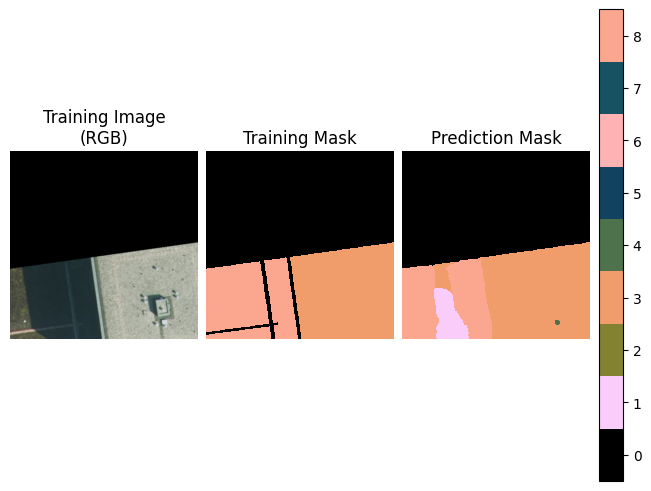

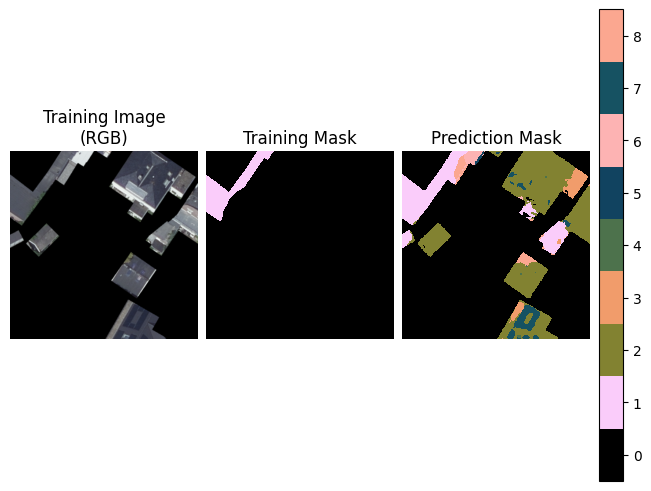

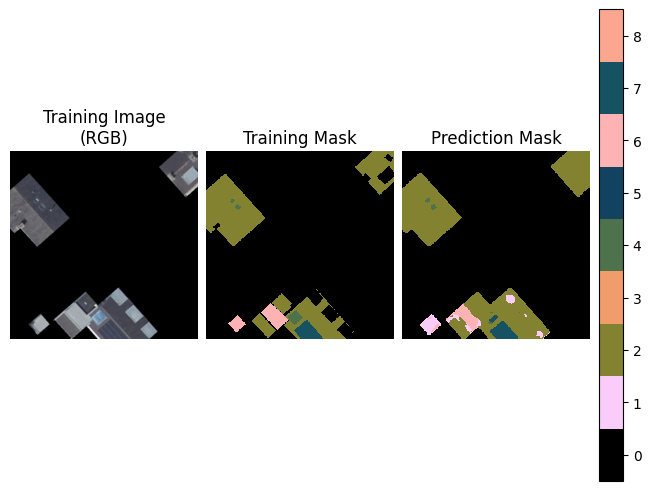

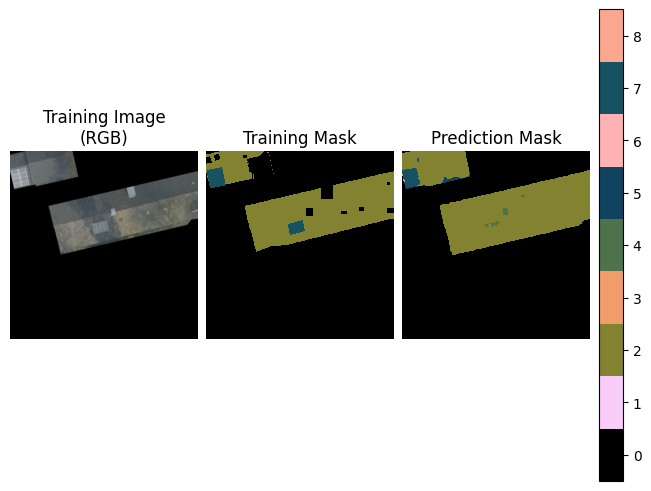

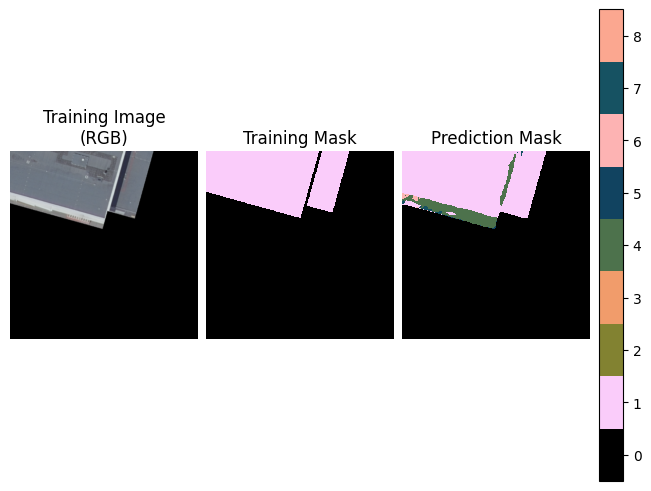

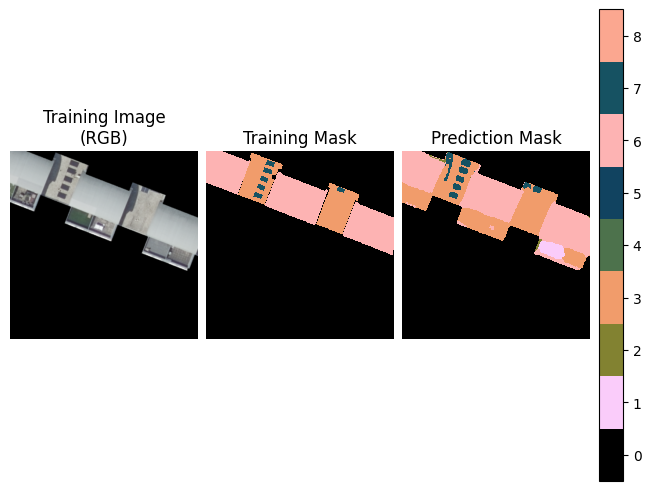

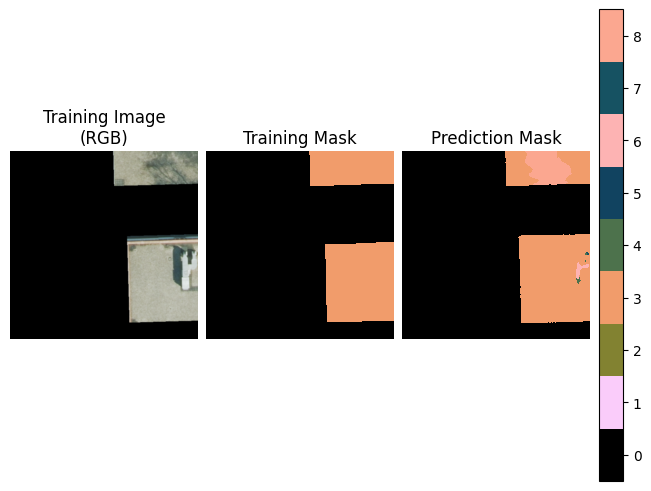

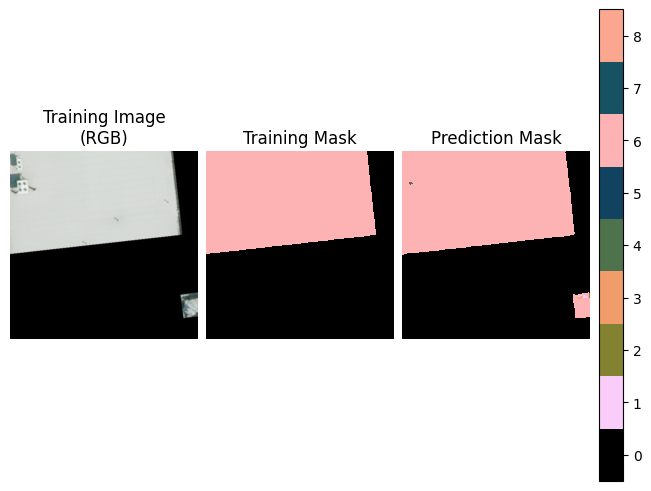

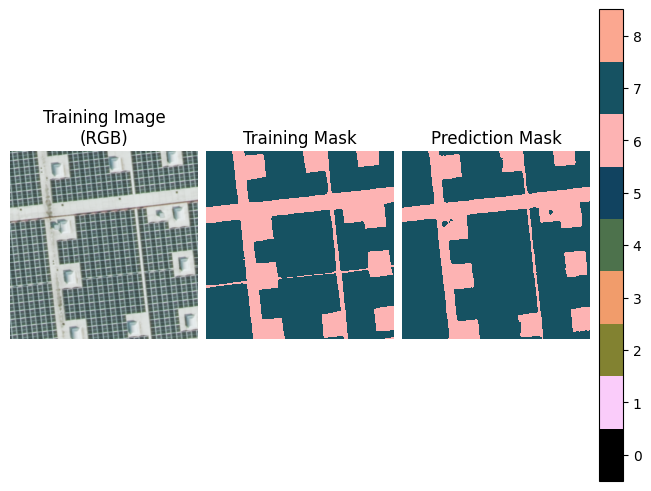

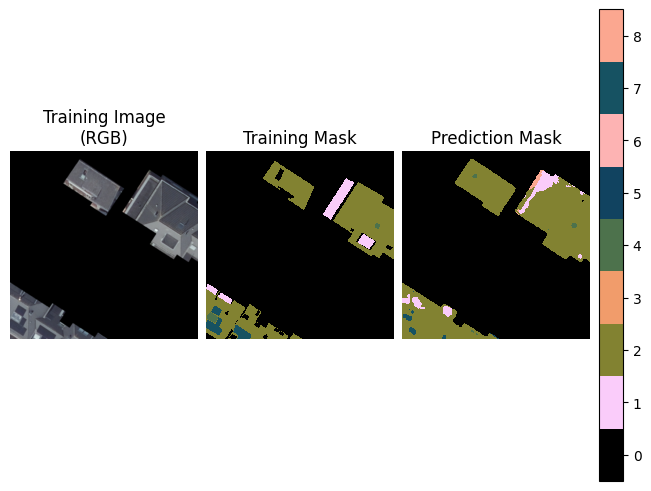

In [1]:
import lightning
import torch
import torchgeo.transforms

from common.augmentations import MinMaxScaling
from training.datamodule import TrainingDataModule
from training.dataset import TrainingDataset
from training.task import TrainingTask

lightning.pytorch.seed_everything(0, workers=True)

torch.set_float32_matmul_precision("high")
torch.backends.cudnn.allow_tf32 = True

datamodule = TrainingDataModule(root="../dataset/temp")
datamodule.setup("fit")

dataset: TrainingDataset = datamodule.val_dataset

model: TrainingTask = TrainingTask.load_from_checkpoint("../logs/RoofSense/best.ckpt",
                                                        map_location="cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.freeze()

scale = torchgeo.transforms.AugmentationSequential(MinMaxScaling(  # TODO: Expose these parameters in the initializer.
    mins=torch.tensor([0, 0, 0, 0, 0]), maxs=torch.tensor([255, 255, 255, 1, 90]), ), data_keys=["image"], )

for i in range(len(dataset)):
    batch = dataset[i]
    batch = scale(batch)
    image: torch.Tensor = batch["image"].to(model.device)
    with torch.inference_mode():
        prediction=model(image).argmax(dim=1).squeeze().cpu()
    batch["prediction"]=prediction
    dataset.plot(batch)